> > # **Convolutional Neural Network (Digit Recognizer)**


# **Importing Dataset Path From Kaggle**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


# **Importing Libraries**

In [25]:
import keras_tuner
import kerastuner
from tensorflow import keras
from keras.datasets import mnist
from matplotlib import pyplot as plt
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from keras.utils import plot_model

# **Reading Our CSV Files**

In [3]:
def data_reading():
    train = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
    print("==================================")
    print("Train data read successfully!!!!")
    test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')
    print("==================================")
    print("Test data read successfully!!!!")
    submission = pd.read_csv('/kaggle/input/digit-recognizer/sample_submission.csv')
    print("==================================")
    print("Submission data read successfully!!!!")
    return train, test, submission
train , test, submission = data_reading()

Train data read successfully!!!!
Test data read successfully!!!!
Submission data read successfully!!!!


In [4]:
print(f"Training data size is {train.shape}\nTesting data size is {test.shape}")

Training data size is (42000, 785)
Testing data size is (28000, 784)


# **Sample Of Dataset**

In [5]:
train.head(3)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
test.head(3)

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
y_train = train["label"]
x_train = train.drop(labels=['label'], axis = 1)

# **Adding More Data**

In [8]:
(x_train1 , y_train1) , (x_test1, y_test1) = mnist.load_data()

train1 = np.concatenate([x_train1,x_test1], axis = 0)
y_train1 = np.concatenate([y_train1,y_test1], axis = 0)
Y_train1 = y_train1
X_train1 = train1.reshape(-1, 28*28)

11490434/11490434 [==============================] - 1s 0us/step


In [9]:
#Normalize data to make CNN faster..
x_train = x_train/2
test = test/255.0
X_train1 = X_train1/255.0


In [10]:
X_train = np.concatenate((X_train1,x_train))
Y_train = np.concatenate((Y_train1, y_train))

In [11]:
X_train = X_train.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

In [12]:
Y_train = to_categorical(Y_train, num_classes=10)

# **Spliting**

In [13]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train,
                                                  test_size=0.1, random_state=2)

In [14]:
X_train.shape , Y_train.shape, X_val.shape, Y_val.shape

((100800, 28, 28, 1), (100800, 10), (11200, 28, 28, 1), (11200, 10))

# **Sample Image**

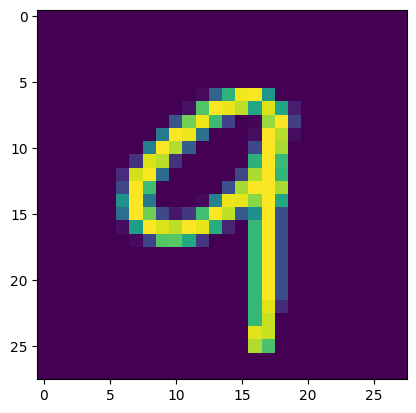

In [15]:
image = plt.imshow(X_train[8])

# **CNN Model Designing**

In [16]:
def build_model(hp):
    model = keras.Sequential()
    
    num_conv_layer = hp.Int('num_con_layer',min_value = 1, max_value = 5, step = 1)
    for i in range(num_conv_layer):
        model.add(keras.layers.Conv2D(filters= hp.Int(f'con_layer{i}_filter', min_value = 32, max_value = 256, step = 32),
                                     kernel_size = (3,3),strides = 1,padding = 'Same',activation='relu',
                                      kernel_initializer= keras.initializers.he_normal,
                                     kernel_regularizer= keras.regularizers.l2(0.001),
                                     input_shape = (28,28,1)))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.MaxPooling2D(pool_size=(3,3),strides=1, padding='Same'))
    model.add(keras.layers.Flatten())
    
    #Tuning the number of dense layer..
    num_dense_layer = hp.Int('num_dense_layer', min_value = 1, max_value = 5, step = 1)
    for i in range(num_dense_layer):
        model.add(keras.layers.Dense(units = hp.Int(f'unit_{i}_layer', min_value = 32, max_value = 512, step = 32),
                                    activation = 'relu',kernel_initializer = keras.initializers.he_normal,
                                    kernel_regularizer = keras.regularizers.l2(0.001)))
        model.add(keras.layers.Dropout(rate=hp.Float(f'dropout_{i}', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(keras.layers.Dense(10, activation= keras.activations.softmax))    
    
    learning_rate = hp.Choice('learning_rate', values = [1e-2,1e-3,1e-4])
    model.compile(optimizer= keras.optimizers.Adam(learning_rate= learning_rate),
                 loss = keras.losses.categorical_crossentropy,
                 metrics= ['accuracy'])
    return model

In [17]:
tuner = keras_tuner.RandomSearch(hypermodel= build_model , objective= 'val_accuracy',max_trials = 10,
                                max_retries_per_trial = 3, directory = '/kaggle/working/',
                                project_name = 'Digit Recognizer')

In [18]:
tuner.search(X_train, Y_train , epochs = 10, validation_data = (X_val, Y_val))

Trial 10 Complete [00h 04m 05s]
val_accuracy: 0.11294642835855484

Best val_accuracy So Far: 0.9880357384681702
Total elapsed time: 01h 24m 30s


In [19]:
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

In [20]:
model1 = tuner.hypermodel.build(best_hps)

# **Model Summary**

In [22]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        640       
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 28, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        18464     
                                                                 
 batch_normalization_2 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                                 
                                                      

# **Model Image**

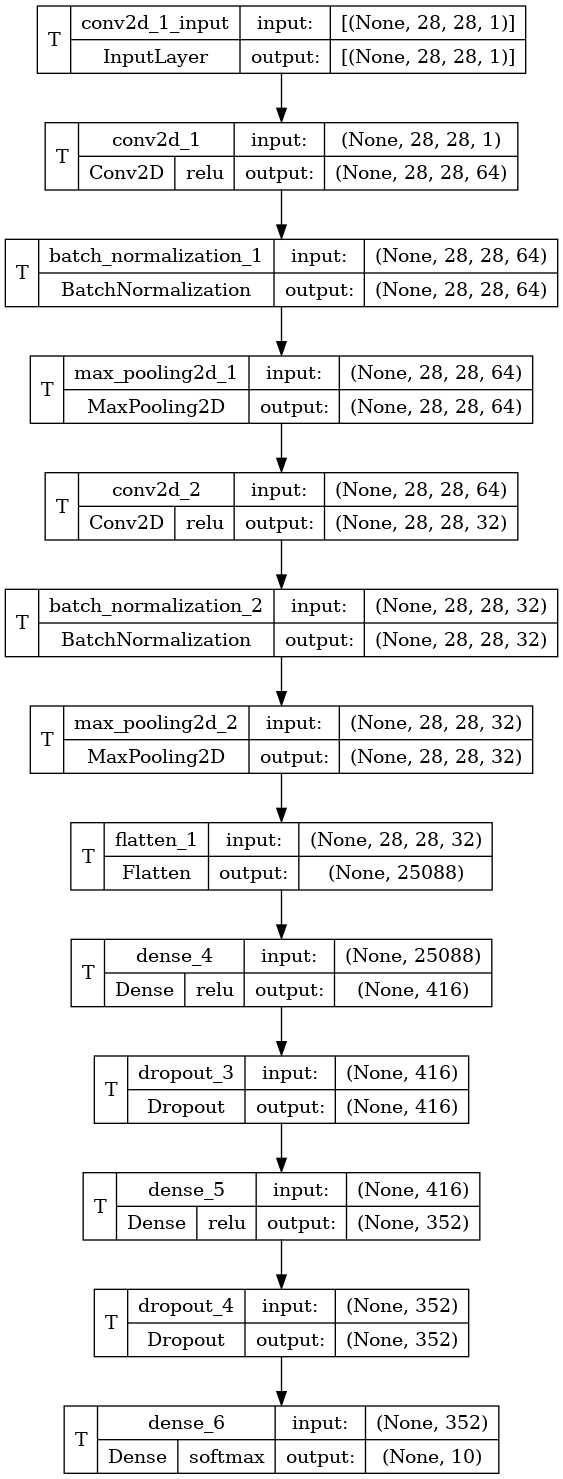

In [27]:
plot_model(model1, to_file='model.png', show_shapes=True, show_layer_names=True,show_layer_activations= True,
          show_trainable= True)
from IPython.display import Image
Image("model.png")

# **Model Training By Train Dataset**

In [24]:
history = model1.fit(X_train, Y_train, epochs = 100, validation_data= (X_val, Y_val))

Epoch 1/100
3150/3150 [==============================] - 20s 6ms/step - loss: 1.9460 - accuracy: 0.8582 - val_loss: 1.2310 - val_accuracy: 0.9682
Epoch 2/100
3150/3150 [==============================] - 18s 6ms/step - loss: 1.1153 - accuracy: 0.9572 - val_loss: 0.8857 - val_accuracy: 0.9786
Epoch 3/100
3150/3150 [==============================] - 18s 6ms/step - loss: 0.8436 - accuracy: 0.9680 - val_loss: 0.7243 - val_accuracy: 0.9819
Epoch 4/100
3150/3150 [==============================] - 18s 6ms/step - loss: 0.6962 - accuracy: 0.9726 - val_loss: 0.6010 - val_accuracy: 0.9831
Epoch 5/100
3150/3150 [==============================] - 18s 6ms/step - loss: 0.5847 - accuracy: 0.9760 - val_loss: 0.5130 - val_accuracy: 0.9838
Epoch 6/100
3150/3150 [==============================] - 18s 6ms/step - loss: 0.4936 - accuracy: 0.9786 - val_loss: 0.4355 - val_accuracy: 0.9836
Epoch 7/100
3150/3150 [==============================] - 18s 6ms/step - loss: 0.4277 - accuracy: 0.9793 - val_loss: 0.3684 -

# **Graph Visualisation**

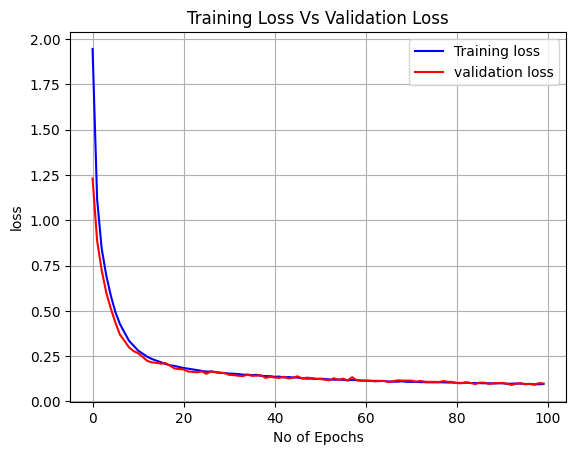

In [39]:
plt.plot(history.history['loss'], color='b', label="Training loss")
plt.plot(history.history['val_loss'], color='r', label="validation loss")
plt.grid()
plt.xlabel("No of Epochs")
plt.ylabel("loss")
plt.title("Training Loss Vs Validation Loss")
plt.legend()
plt.plot()
plt.show()



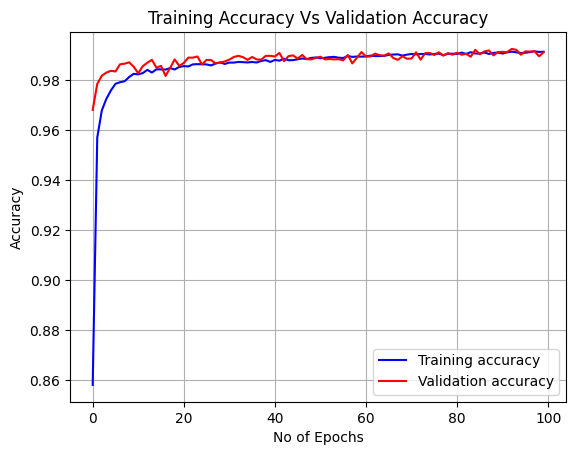

In [40]:
plt.plot(history.history['accuracy'], color='b', label="Training accuracy")
plt.plot(history.history['val_accuracy'], color='r', label="Validation accuracy")
plt.grid()
plt.xlabel("No of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy Vs Validation Accuracy")
plt.legend()
plt.plot()
plt.show()


# **Prediction On Test Dataset**

In [35]:
# Predict the values from the validation dataset
Y_pred = model1.predict(test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1)

875/875 [==============================] - 1s 2ms/step


In [36]:
Y_pred_classes

array([2, 0, 9, ..., 3, 9, 2])

In [37]:
results = pd.Series(Y_pred_classes,name="Label")

# **File Submission**

In [38]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("Digit_Recognizer.csv",index=False)

In [42]:
model1.save(filepath= 'C:\\Users\\EXCELL  COMPUTERS\\Programming_Data_Science\\Convolutional_Neural_Network',
           save_format= 'h5',include_optimizer= True,save_traces=True)